In [1]:
from wrapper_functions import *

2023-02-23 15:47:07.355074: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Users/liyanran/opt/anaconda3/envs/BNE/lib/python3.7/site-packages/gpflow/experimental/utils.py:43: UserWarning: You're calling gpflow.experimental.check_shapes.decorator.check_shapes which is considered *experimental*. Expect: breaking changes, poor documentation, and bugs.
  f"You're calling {name} which is considered *experimental*."
/Users/liyanran/opt/anaconda3/envs/BNE/lib/python3.7/site-packages/gpflow/experimental/utils.py:43: UserWarning: You're calling gpflow.experimental.check_shapes.inheritance.inherit_check_shapes which is considered *experimental*. Expect: breaking changes, poor documentation, and bugs.
  f"You're calling {name} which i

TensorFlow version: 2.10.0. Expected: 2.7.0
TensorFlow Probability version: 0.18.0. Expected: 0.15.0


2023-02-23 15:47:55.346311: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Experiment II: 2D Spatial Field

### Model Configs

In [2]:
# Optimization configs. 
# Consider reduce below parameters / set to `False` if MCMC is taking too long:
# mcmc_num_steps, mcmc_burnin, mcmc_nchain, mcmc_initialize_from_map.
map_step_size=5e-4   # @param
map_num_steps=10_000  # @param

mcmc_step_size=1e-4 # @param
mcmc_num_steps=1000 # @param

mcmc_nchain=10 # @param
mcmc_burnin=2_500 # @param
bne_mcmc_initialize_from_map="True" # @param ["False", "True"]

bne_mcmc_initialize_from_map = eval(bne_mcmc_initialize_from_map)


In [3]:
# BMA parameters.
y_noise_std = 0.01  # Note: Changed from 0.1 # @param
bma_gp_lengthscale = .5 # @param
bma_gp_l2_regularizer = 0.7 # @param

bma_n_samples_train = 100 # @param
bma_n_samples_eval = 250 # @param
bma_n_samples_test = 250 # @param
bma_seed = 0 # @param


In [4]:
# BNE parameters.
bne_gp_lengthscale = .06 # 5. # @param
bne_gp_l2_regularizer = 1. # 15 # @param
bne_variance_prior_mean = -2.5 # @param
bne_skewness_prior_mean = -2.5 # @param
bne_seed = 0 # @param

### Read training/prediction data

In [5]:
training_eastMA = pd.read_csv('./data/training_dataset/training_eastMA.csv')
training_eastMA_noMI = training_eastMA[:51]
training_eastMA_folds = pd.read_csv('./data/training_dataset/training_eastMA_folds.csv')
base_model_predictions_eastMA = pd.read_csv('./data/prediction_dataset/base_model_predictions_eastMA.csv')
display(training_eastMA.shape, training_eastMA_folds.shape, base_model_predictions_eastMA.shape)
print("pred longitude max and min", base_model_predictions_eastMA["lon"].max(),base_model_predictions_eastMA["lon"].min())
print("pred latitude max and min", base_model_predictions_eastMA["lat"].max(),base_model_predictions_eastMA["lat"].min())
#list(base_model_predictions_eastMA.columns)
print("train longitude max and min", training_eastMA["lon"].max(),training_eastMA["lon"].min())
print("train latitude max and min", training_eastMA["lat"].max(),training_eastMA["lat"].min())


training51= pd.read_csv('./data/training_dataset/training51.csv')

FileNotFoundError: [Errno 2] No such file or directory: './data/training_dataset/training_eastMA.csv'

In [ ]:
# standardize
X_train1 = np.asarray(training_eastMA_noMI[["lon", "lat"]].values.tolist()).astype(np.float32)
X_test1 = np.asarray(base_model_predictions_eastMA[["lon", "lat"]].values.tolist()).astype(np.float32)
X_valid = np.concatenate((X_train1, X_test1), axis=0)
X_centr = np.mean(X_valid, axis=0)
X_scale = np.max(X_valid, axis=0) - np.min(X_valid, axis=0)

X_train1 = (X_train1 - X_centr) / X_scale
X_test1 = (X_test1 - X_centr) / X_scale

Y_train = np.expand_dims(training_eastMA_noMI["aqs"], 1).astype(np.float32)
#Y_test = np.expand_dims(base_model_predictions_eastMA["pred_av"], 1).astype(np.float32)

print("2011 center and scale: ", X_centr, X_scale)

In [ ]:
base_model_names = ["pred_av", "pred_gs", "pred_caces"]
base_preds_train = tf.stack([training_eastMA_noMI[base_model_name].astype(np.float32) for base_model_name in base_model_names], axis=-1)
base_preds_test = tf.stack([base_model_predictions_eastMA[base_model_name].astype(np.float32) for base_model_name in base_model_names], axis=-1)
#base_preds_test
display(base_preds_train.shape, base_preds_test.shape)

## Bayesian Model Averaging

A Bayesian ensemble model where ensemble weights $w_k's$ are parameterized by Gaussian process priors:

$y \sim N(\mu(x), \sigma^2)$ 

$\mu(x) = \sum_{k=1}^K w_k(x) * m_k(x) \quad$  where $\{m_k\}_{k=1}^K$ are base model predictions.

$w(x) = softmax(f(x)) \qquad\;\;\;$ where $w=[w_1, \dots, w_K]$ and $f=[f_1, \dots, f_K]$

$f \stackrel{i.i.d.}{\sim} GaussianProcess(0, k)$




In [ ]:
# Assemble into configs.
from distutils.log import debug


bma_model_config = DEFAULT_GP_CONFIG.copy()
map_config = DEFAULT_MAP_CONFIG.copy()
mcmc_config = DEFAULT_MCMC_CONFIG.copy()

bma_model_config.update(dict(lengthscale=bma_gp_lengthscale,
                             l2_regularizer=bma_gp_l2_regularizer,
                             y_noise_std=y_noise_std))

map_config.update(dict(learning_rate=map_step_size,
                       num_steps=map_num_steps))

mcmc_config.update(dict(step_size=mcmc_step_size, 
                        num_steps=mcmc_num_steps,
                       burnin=mcmc_burnin,
                       nchain=mcmc_nchain))

In [ ]:
display(bma_model_config, map_config, mcmc_config)

### Build model

In [ ]:
bma_prior, bma_gp_config = bma_dist(X_train1, 
                                    base_preds_train, 
                                    **bma_model_config)

bma_model_config.update(bma_gp_config)

# Check if the model graph is specified correctly.
bma_prior.resolve_graph()

In [ ]:
def run_posterior_inference(model_dist: tfd.Distribution, 
                            Y: tf.Tensor, 
                            mcmc_config: Dict[str, Any], 
                            map_config: Optional[Dict[str, Any]] = None, 
                            model_config: Optional[Dict[str, Any]] = None,
                            initialize_from_map: bool = True):
  """Wrapper function for running MCMC with MAP initialization."""
  # Defines posterior log likelihood function, and also a 
  # randomly-sampled initial state from model prior.
  nchain = mcmc_config['nchain']
  init_state, target_log_prob_fn = prepare_mcmc(model_dist, Y, nchain=nchain)  
  
  if initialize_from_map:
    # Initializes at MAP, shape (num_chains, param_shape_0, param_shape_1).
    print('Running MAP:', end='\t')
    init_state = run_map(target_log_prob_fn=target_log_prob_fn, 
                         gp_config=model_config,
                         **map_config)

    init_state = tf.stack([init_state] * mcmc_nchain, axis=0)

  # Run MCMC, shape (param_shape_0, param_shape_1, num_chains).
  print('Running MCMC:', end='\t')
  gp_w_samples, chain_samples, sampler_stat = run_mcmc(init_state=init_state,
                             target_log_prob_fn=target_log_prob_fn,
                             debug_mode=True,
                             **mcmc_config)  
  
  return gp_w_samples, chain_samples, sampler_stat

In [ ]:
# display(bma_model_config, map_config,mcmc_config, bma_prior)

### Run MCMC

In [ ]:
bma_gp_w_samples, chain_samples, sampler_stat = run_posterior_inference(model_dist=bma_prior, 
                                           model_config=bma_model_config,
                                           Y=Y_train, 
                                           map_config=map_config,
                                           mcmc_config=mcmc_config)

# Above the debug mode

# bma_gp_w_samples = run_posterior_inference(model_dist=bma_prior, 
#                                            model_config=bma_model_config,
#                                            Y=Y_train, 
#                                            map_config=map_config,
#                                            mcmc_config=mcmc_config)


bma_joint_samples = make_bma_samples(X_test1, None, base_preds_test, 
                                     bma_weight_samples=bma_gp_w_samples[0],
                                     bma_model_config=bma_model_config,
                                     n_samples=bma_n_samples_eval, 
                                     seed=bne_seed,
                                     y_samples_only=False)



In [ ]:
plt.plot(chain_samples[:, 8, 1011, 2], c='b', alpha=.3)
# plt.title('Traceplot')
# plt.plot(bma_gp_w_samples[1][:,9, 127, 1].numpy(), 'b')
# plt.xlabel('Iteration')
# plt.ylabel('Position')
plt.show()

In [ ]:
#np.mean((means_pred - means_true)**2) / np.var(means_true)
# mse = tf.reduce_mean((means_train_mcmc-Y_train_mcmc)** 2)/ np.var(Y_train_mcmc)
# mse
def rmse(y_obs, y_pred):
    return np.sqrt(np.mean((y_obs - y_pred) ** 2))
bma_mcmc_rmse = rmse(means_train_mcmc, Y_train_mcmc)

reg = LinearRegression().fit(X_train1, Y_train)
y_pred = reg.predict(X_train1)
rmse_lr = mean_squared_error(y_true=Y_train, y_pred=y_pred, squared=False)
display(rmse_lr, bma_mcmc_rmse)

### Prepare Data for BAE/BNE

In [ ]:
# Construct data from BMA samples, shapes (num_samples * num_data, ...)
means_train_mcmc, X_train_mcmc, Y_train_mcmc = make_bma_samples(
    X_train1, Y_train, base_preds_train, 
    bma_weight_samples=bma_gp_w_samples[0],
    bma_model_config=bma_model_config,
    n_samples=bma_n_samples_train,
    seed=bma_seed, 
    prepare_mcmc_training=True)

# Mean samples based on test data, shape (num_samples, num_data, num_output).
# It is used to generate final examples in `make_bne_samples()`.
means_test_mcmc = make_bma_samples(
    X_test1, None, base_preds_test, 
    bma_weight_samples=bma_gp_w_samples[0],
    bma_model_config=bma_model_config,
    n_samples=bma_n_samples_test,
    seed=bma_seed)

In [ ]:
display(means_train_mcmc.shape, X_train_mcmc.shape, Y_train_mcmc.shape, means_test_mcmc.shape)

## Bayesian Additive Ensemble

Given $\mu(x)$ the posterior of a Bayesian ensemble model, the Bayesian Additive Ensemble is defined as:    

$y \sim N(\mu(x) + r(x), \sigma^2)$

$r \sim GaussianProcess(0, k)$

The additive ensemble $r(x)$ services two purposes: 

1. Mitigates systematic bias in model prediction; 
2. Quantifies the model's epistemic uncertainty.

In [ ]:
# # # BNE GP Configs.
# # lengthscale = 1. # @param
# # l2_regularizer = 10. # @param

# BNE model configs. 
# If estimate_mean=False, only estimates a constant variance on top of the 
# original model.
estimate_mean = "True" # @param ["True", "False"]
variance_prior_mean=0. # @param
# # MAP and MCMC configs
# map_step_size=0.1 # @param
# map_num_steps=10_000 # @param

# mcmc_step_size=1e-2 # @param
# mcmc_num_steps=10_000 # @param

bne_gp_config = DEFAULT_GP_CONFIG.copy()
bne_model_config = DEFAULT_BNE_CONFIG.copy()

map_config = DEFAULT_MAP_CONFIG.copy()
mcmc_config = DEFAULT_MCMC_CONFIG.copy()


bne_gp_config.update(dict(lengthscale=bne_gp_lengthscale, 
                          l2_regularizer=bne_gp_l2_regularizer))
bne_model_config.update(dict(estimate_mean=eval(estimate_mean),
                             variance_prior_mean=variance_prior_mean,
                             **bne_gp_config))

map_config.update(dict(learning_rate=map_step_size,
                       num_steps=map_num_steps))
mcmc_config.update(dict(step_size=mcmc_step_size, 
                        num_steps=mcmc_num_steps,
                       burnin=mcmc_burnin,
                       nchain=mcmc_nchain))

### Build Model

In [ ]:
# Construct posterior sampler.
bne_prior, bne_gp_config = bne_model_dist(
    inputs=X_train_mcmc,
    mean_preds=means_train_mcmc,
    **bne_model_config)

bne_model_config.update(bne_gp_config)
print(f'prior model graph: {bne_prior.resolve_graph()}')

In [ ]:
display(bne_prior, bne_model_config, map_config, mcmc_config)

### Run MCMC

In [ ]:
# Estimates GP weight posterior using MCMC.
bne_gp_w_samples, chain_samples, sampler_stat = run_posterior_inference(model_dist=bne_prior,
                                           model_config=bne_gp_config,
                                           Y=Y_train_mcmc,
                                           map_config=map_config,
                                           mcmc_config=mcmc_config,
                                           initialize_from_map=True)
# Generates the posterior sample for all model parameters. 
bne_joint_samples = make_bne_samples(X_test1,
                                     mean_preds=means_test_mcmc,
                                     bne_model_config=bne_model_config,
                                     bne_weight_samples=bne_gp_w_samples[0],
                                     seed=bne_seed)

In [ ]:
plt.plot(chain_samples[:, 9, 791, 1], c='b', alpha=.3)
# plt.title('Traceplot')
# plt.plot(bma_gp_w_samples[1][:,9, 127, 1].numpy(), 'b')
# plt.xlabel('Iteration')
# plt.ylabel('Position')
plt.show()

### 10-fold cross validation check

In [6]:
# Optimization configs. 
# Consider reduce below parameters / set to `False` if MCMC is taking too long:
# mcmc_num_steps, mcmc_burnin, mcmc_nchain, mcmc_initialize_from_map.
map_step_size=5e-4   # @param
map_num_steps=10_000  # @param

mcmc_step_size=1e-4 # @param
mcmc_num_steps=1000 # @param

mcmc_nchain=10 # @param
mcmc_burnin=2_500 # @param
bne_mcmc_initialize_from_map="True" # @param ["False", "True"]

bne_mcmc_initialize_from_map = eval(bne_mcmc_initialize_from_map)


# BMA parameters.
y_noise_std = 0.01  # Note: Changed from 0.1 # @param
bma_gp_lengthscale = .55 # @param
bma_gp_l2_regularizer = .8 # @param

bma_n_samples_train = 100 # @param
bma_n_samples_eval = 250 # @param
bma_n_samples_test = 250 # @param
bma_seed = 0 # @param


# BNE parameters.
bne_gp_lengthscale = .05 # 5. # @param
bne_gp_l2_regularizer = 1. # 15 # @param
bne_variance_prior_mean = -2.5 # @param
bne_skewness_prior_mean = -2.5 # @param
bne_seed = 0 # @param


# ### Read training/prediction data
training_eastMA = pd.read_csv('../data/training_dataset/training_eastMA.csv')
training_eastMA_noMI = training_eastMA[:51]
training_eastMA_folds = pd.read_csv('../data/training_dataset/training_eastMA_folds.csv')
base_model_predictions_eastMA = pd.read_csv('../data/prediction_dataset/base_model_predictions_eastMA.csv')

print("pred longitude max and min", base_model_predictions_eastMA["lon"].max(),base_model_predictions_eastMA["lon"].min())
print("pred latitude max and min", base_model_predictions_eastMA["lat"].max(),base_model_predictions_eastMA["lat"].min())
#list(base_model_predictions_eastMA.columns)
print("train longitude max and min", training_eastMA["lon"].max(),training_eastMA["lon"].min())
print("train latitude max and min", training_eastMA["lat"].max(),training_eastMA["lat"].min())


training51= pd.read_csv('../data/training_dataset/training51.csv')

# standardize
X_train1 = np.asarray(training_eastMA_noMI[["lon", "lat"]].values.tolist()).astype(np.float32)
X_test1 = np.asarray(base_model_predictions_eastMA[["lon", "lat"]].values.tolist()).astype(np.float32)
X_valid = np.concatenate((X_train1, X_test1), axis=0)
X_centr = np.mean(X_valid, axis=0)
X_scale = np.max(X_valid, axis=0) - np.min(X_valid, axis=0)

X_train1 = (X_train1 - X_centr) / X_scale
X_test1 = (X_test1 - X_centr) / X_scale

Y_train = np.expand_dims(training_eastMA_noMI["aqs"], 1).astype(np.float32)
#Y_test = np.expand_dims(base_model_predictions_eastMA["pred_av"], 1).astype(np.float32)

print("2011 center and scale: ", X_centr, X_scale)


base_model_names = ["pred_av", "pred_gs", "pred_caces"]
base_preds_train = tf.stack([training_eastMA_noMI[base_model_name].astype(np.float32) for base_model_name in base_model_names], axis=-1)
base_preds_test = tf.stack([base_model_predictions_eastMA[base_model_name].astype(np.float32) for base_model_name in base_model_names], axis=-1)


# Assemble into configs.
bma_model_config = DEFAULT_GP_CONFIG.copy()
map_config = DEFAULT_MAP_CONFIG.copy()
mcmc_config = DEFAULT_MCMC_CONFIG.copy()

bma_model_config.update(dict(lengthscale=bma_gp_lengthscale,
                             l2_regularizer=bma_gp_l2_regularizer,
                             y_noise_std=y_noise_std,
                             #activation='relu',
                             activation_func='softmax'))

map_config.update(dict(learning_rate=map_step_size,
                       num_steps=map_num_steps))

mcmc_config.update(dict(step_size=mcmc_step_size, 
                        num_steps=mcmc_num_steps,
                       burnin=mcmc_burnin,
                       nchain=mcmc_nchain,
                       debug_mode=False))

pred longitude max and min -69.93 -73.5
pred latitude max and min 44.3 40.6
train longitude max and min -70.023598 -73.443056
train latitude max and min 44.107524 40.74529
2011 center and scale:  [-72.185104  42.680347] [3.5699997 3.7000008]


In [71]:
kf = KFold(n_splits=10, random_state=bma_seed, shuffle=True) 

rmse_lr = []
rmse_gam = []
rmse_bma = []

nll_lr, nll_gam, nll_bma = [], [], []

# initialize a dataframe to store lon, lat and raw error
error_df = pd.DataFrame(columns=['lon', 'lat', 'raw_error'])

coverage_lr = 0
coverage_gam = 0
coverage_bma = 0

import rpy2
#from rpy2.robjects import pandas2ri
from rpy2 import robjects as ro
from rpy2.robjects.packages import importr
import pandas as pd
import rpy2.robjects as ro
from rpy2.robjects import pandas2ri, r
from rpy2.robjects.conversion import localconverter
# import R's "base" package
base = importr('base')
#ms = importr('MSGARCH')
# import R's "utils" package
utils = importr('utils')

with localconverter(ro.default_converter + pandas2ri.converter):
  # convert "lon" and "lat" in training_eastMA_noMI into scaled X_train1 values
  training_eastMA_noMI["lon"] = (training_eastMA_noMI["lon"] - X_centr[0]) / X_scale[0]
  training_eastMA_noMI["lat"] = (training_eastMA_noMI["lat"] - X_centr[1]) / X_scale[1]
  r_from_pd_df = ro.conversion.py2rpy(training_eastMA_noMI)


mgcv  = importr('mgcv')
stats = importr('stats')
ciTools = importr('ciTools')


#ref_model = LinearRegression()
kf = KFold(n_splits=10, random_state=bma_seed, shuffle=True) 


for train_index, test_index in kf.split(X_train1):
    #print("Train:", train_index, "Validation:",test_index)
    X_tr, X_te = X_train1[train_index], X_train1[test_index] 
    Y_tr, Y_te = Y_train[train_index], Y_train[test_index]

    base_preds_tr, base_preds_te = base_preds_train.numpy()[train_index], base_preds_train.numpy()[test_index]
    print(train_index, test_index)
    print(X_tr.shape, X_te.shape, Y_tr.shape, Y_te.shape, base_preds_tr.shape, base_preds_te.shape)

    r_dat_py = training_eastMA_noMI
      
    with localconverter(ro.default_converter + pandas2ri.converter):
        r_tr = ro.conversion.py2rpy(r_dat_py.iloc[train_index])
        r_te = ro.conversion.py2rpy(r_dat_py.iloc[test_index])

    # Ref: lr
    lr_model = stats.lm(ro.Formula('aqs~pred_av+pred_gs+pred_caces'), data=r_tr)
    l = ciTools.add_pi(r_te, lr_model)
    lr_pred = l[7]
    lr_ci_l, lr_ci_u = l[8], l[9]
    coverage_lr += np.sum([(Y_te[i] > lr_ci_l[i]) & (Y_te[i] < lr_ci_u[i]) for i in range(len(Y_te))])
    rmse_lr.append(rmse(Y_te, np.asanyarray(lr_pred).reshape(-1,1)))
    nll_lr.append(nll(Y_te, np.asanyarray(lr_pred).reshape(-1,1)))
    print(rmse_lr)

    # Ref: GAM
    #df = training_eastMA_noMI.iloc[train_index]
    gam_model = mgcv.gam(ro.Formula('aqs ~ s(lon, lat, by=pred_av, k=4) + s(lon, lat,by=pred_gs, k=4) +s(lon, lat, by=pred_caces, k=4)'), data=r_tr)
    a= ciTools.add_pi(r_te, gam_model)
    gam_pred = a[7]
    gam_ci_l, gam_ci_u = a[8], a[9]
    coverage_gam += np.sum([(Y_te[i] > gam_ci_l[i]) & (Y_te[i] < gam_ci_u[i]) for i in range(len(Y_te))])
    rmse_gam.append(rmse(Y_te, np.asanyarray(gam_pred).reshape(-1,1)))
    nll_gam.append(nll(Y_te, np.asanyarray(gam_pred).reshape(-1,1)))
    print(rmse_gam)

    # build model & run MCMC
    #fixed_input_tr = tf.ones((X_tr.shape[0], 2), dtype=tf.float32)
    bma_prior, bma_gp_config = bma_dist(X_tr, 
                                    base_preds_tr, 
                                    **bma_model_config)

    bma_model_config.update(bma_gp_config)


    bma_gp_w_samples = run_posterior_inference(model_dist=bma_prior, 
                                           model_config=bma_model_config,
                                           Y=Y_tr, 
                                           map_config=map_config,
                                           mcmc_config=mcmc_config)

    #fixed_input_te = tf.ones((X_te.shape[0], 2), dtype=tf.float32)
    bma_joint_samples = make_bma_samples(X_te, None, base_preds_te, 
                                     bma_weight_samples=bma_gp_w_samples[0],
                                     bma_model_config=bma_model_config,
                                     n_samples=bma_n_samples_eval, 
                                     seed=bne_seed,
                                     y_samples_only=False)
    y_pred = bma_joint_samples['y']
    y_pred = tf.reduce_mean(y_pred, axis=0)
    raw_error = pd.DataFrame(columns=['lon', 'lat', 'raw_error'])
    raw_error["lon"] = X_te[:,0]
    raw_error["lat"] = X_te[:,1]
    raw_error["raw_error"] = (y_pred - Y_te).numpy().reshape(-1)
    error_df = error_df.append(raw_error)

    pred_std = calc_prediction_std(y_pred, Y_te)
    pred_mean = tf.reduce_mean(y_pred, axis=1)
    bma_pi = np.array([(pred_mean - 1.96*pred_std).numpy(), (pred_mean + 1.96*pred_std).numpy()])
    coverage_bma += np.sum([(Y_te[i] > bma_pi[0][i]) & (Y_te[i] < bma_pi[1][i]) for i in range(len(Y_te))])
    rmse_bma.append(rmse(Y_te, y_pred))
    nll_bma.append(nll(Y_te, y_pred))
    print(rmse_bma)
    # Investigate what examples (e.g., in terms of spatial coordinate) tend to receive high error.

  

print("RMSE LR: ", np.mean(rmse_lr), np.median(rmse_lr), np.std(rmse_lr))
print("RMSE GAM: ", np.mean(rmse_gam), np.median(rmse_gam), np.std(rmse_gam))
print("RMSE BMA: ", np.mean(rmse_bma), np.median(rmse_bma), np.std(rmse_bma))

print("NLL LR: ", np.mean(nll_lr), np.median(nll_lr), np.std(nll_lr))
print("NLL GAM: ", np.mean(nll_gam), np.median(nll_gam), np.std(nll_gam))
print("NLL BMA: ", np.mean(nll_bma), np.median(nll_bma), np.std(nll_bma))

print("Coverage LR: ", coverage_lr/len(Y_train))
print("Coverage GAM: ", coverage_gam/len(Y_train))
print("Coverage BMA: ", coverage_bma/len(Y_train))

lr_s = ['', str(np.mean(rmse_lr)), str(np.std(rmse_lr))]
gam_s = ['', str(np.mean(rmse_gam)), str(np.std(rmse_gam))]
bma_s = [ str(np.mean(rmse_bma)), str(np.std(rmse_bma))]

print(error_df)

/Users/liyanran/opt/anaconda3/envs/BNE/lib/python3.7/site-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/liyanran/opt/anaconda3/envs/BNE/lib/python3.7/site-packages/ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


[ 0  1  3  4  5  6  7  8  9 12 13 14 15 16 17 18 19 20 21 23 24 25 26 27
 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50] [ 2 10 11 22 28 29]
(45, 2) (6, 2) (45, 1) (6, 1) (45, 3) (6, 3)
[0.4849554265795824]
[0.4076126206593953]
activation function used softmax
Running MAP:	387067.9375...200588.046875...191452.796875...187640.9375...185059.046875...182308.078125...179543.078125...176688.125...173715.828125...170847.859375...Done.
Running MCMC:	Acceptance Ratio: 0.7424561381340027
activation function used softmax
[0.5171763]
[ 0  1  2  3  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 27 28 29 30 31 34 35 36 37 38 39 40 41 42 43 44 46 47 48 49 50] [ 4 26 32 33 45]
(46, 2) (5, 2) (46, 1) (5, 1) (46, 3) (5, 3)
[0.4849554265795824, 0.5286288478541905]
[0.4076126206593953, 0.6200543960971059]
activation function used softmax
Running MAP:	392355.21875...205900.859375...195325.765625...190649.0625...187977.515625...185997.0...184067.875...181466.234375...177930

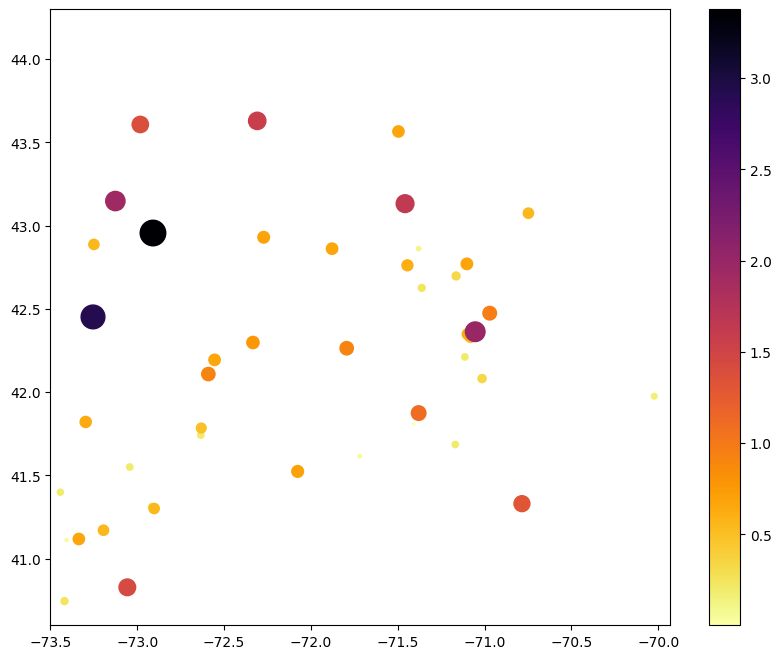

In [107]:
# change error_df lon and lat to un normalized values
plt_df = error_df.copy()
plt_df["lon"] = plt_df["lon"] * X_scale[0] + X_centr[0]
plt_df["lat"] = plt_df["lat"] * X_scale[1] + X_centr[1]
# abs error
plt_df["abs_error"] = abs(plt_df["raw_error"])
# plot error_df ordered by abs raw_error
plt_df = plt_df.sort_values(by=['abs_error'])
plt_df = plt_df.reset_index(drop=True)
plt.figure(figsize=(10, 8))
plt.scatter(plt_df["lon"], plt_df["lat"], c=plt_df["abs_error"],
            s=abs(plt_df["raw_error"])*100, cmap='inferno_r')
cbar = plt.colorbar()
# larger points are more error
coordinate = np.asarray(base_model_predictions_eastMA[["lon", "lat"]].values.tolist()).astype(np.float32)

# limitation x y axis from coordinate
plt.xlim(min(coordinate[:,0]), max(coordinate[:,0]))
plt.ylim(min(coordinate[:,1]), max(coordinate[:,1]))

# plt_df.plot.scatter(x='lon', y='lat', c='abs_error', s=abs(plt_df["raw_error"])*100,
#                       colormap='inferno_r', figsize=(10, 8))

plt.show()


In [283]:
# extract the worst predictions and find them in the original dataset "training_eastMA_noMI"
# change error_df lon and lat to un normalized values
plt_df5 = error_df.copy()

plt_df5["abs_error"] = abs(plt_df5["raw_error"])
# plot error_df ordered by abs raw_error
plt_df5 = plt_df5.sort_values(by=['abs_error'])
plt_df5 = plt_df5.reset_index(drop=True)

df6 = plt_df5.tail(10).round(5)

df6["lon"] = df6["lon"].astype(float).round(5)
# show them in the original dataset
training_eastMA_noMI.loc[training_eastMA_noMI['lon'].round(
    5) == df6["lon"].iloc[1]]
df5 = pd.DataFrame(columns=training_eastMA_noMI.columns)
for i in range(len(df6)):
    df5 = df5.append(
    training_eastMA_noMI.loc[training_eastMA_noMI['lon'].round(
        5) == df6["lon"].iloc[i]])

df5

,mon_id,aqs,pred_av,pred_gs,pred_caces,lon,lat
19,Rhode Island-Providence-0026-88101-1,9.955856,9.5,9.603328,9.027592,0.225528,-0.217751
7,Massachusetts-Dukes-0001-88502-1,6.346957,5.4,9.257568,8.499855,0.392123,-0.364832
49,Vermont-Rutland-0002-88101-1,10.387156,8.6,9.423113,9.105349,-0.223438,0.250732
1,New York-Suffolk-0009-88502-3,8.396442,8.6,11.200440,10.367752,-0.244380,-0.500637
46,New Hampshire-Merrimack-1006-88101-1,8.909402,8.9,8.922614,7.537278,0.203602,0.122193
47,Vermont-Bennington-8001-88502-1,3.886408,4.1,8.559377,5.990102,-0.263647,0.126440
31,Massachusetts-Suffolk-0043-88101-1,10.250689,9.2,8.050020,8.512729,0.316752,-0.085743
34,Massachusetts-Berkshire-0006-88502-3,11.023407,8.2,8.156252,8.812862,-0.299716,-0.061711
44,Vermont-Windham-9000-88502-1,1.580000,4.2,8.406383,5.113718,-0.202996,0.074528


In [284]:
plt_df5.tail(10)


,lon,lat,raw_error,abs_error
41,0.225527,-0.217751,-1.098531,1.098531
42,0.392123,-0.364832,1.315563,1.315563
43,-0.223439,0.250732,-1.385115,1.385115
44,-0.244380,-0.500637,1.437589,1.437589
45,-0.034845,0.256556,1.558877,1.558877
46,0.203602,0.122193,-1.637776,1.637776
47,-0.263646,0.126440,1.930435,1.930435
48,0.316752,-0.085743,-1.988200,1.988200
49,-0.299716,-0.061710,-2.923090,2.923090
50,-0.202995,0.074528,3.377705,3.377705


In [41]:
# index the third/ten fold of the data
rmse_bma_check = []
coverage_bma_check = 0

for i, (train_index, test_index) in enumerate(kf.split(X_train1)):
    if i == 2 or i == 9:
        X_tr, X_te = X_train1[train_index], X_train1[test_index]
        Y_tr, Y_te = Y_train[train_index], Y_train[test_index]
        
        base_preds_tr, base_preds_te = base_preds_train.numpy()[train_index], base_preds_train.numpy()[test_index]
        print(train_index, test_index)
        # build model & run MCMC
        #fixed_input_tr = tf.ones((X_tr.shape[0], 2), dtype=tf.float32)
        r_dat_py = training_eastMA_noMI
      
        with localconverter(ro.default_converter + pandas2ri.converter):
            r_tr = ro.conversion.py2rpy(r_dat_py.iloc[train_index])
            r_te = ro.conversion.py2rpy(r_dat_py.iloc[test_index])

        # Ref: lr
        lr_model = stats.lm(ro.Formula('aqs~pred_av+pred_gs+pred_caces'), data=r_tr)
        l = ciTools.add_pi(r_te, lr_model)
        lr_pred = l[7]


         # Ref: GAM
        #df = training_eastMA_noMI.iloc[train_index]
        gam_model = mgcv.gam(ro.Formula('aqs ~ s(lon, lat, by=pred_av, k=4) + s(lon, lat,by=pred_gs, k=4) +s(lon, lat, by=pred_caces, k=4)'), data=r_tr)
        a= ciTools.add_pi(r_te, gam_model)
        gam_pred = a[7]


        bma_prior, bma_gp_config = bma_dist(X_tr,
                                        base_preds_tr,
                                        **bma_model_config)

        bma_model_config.update(bma_gp_config)

        bma_gp_w_samples = run_posterior_inference(model_dist=bma_prior,
                                               model_config=bma_model_config,
                                               Y=Y_tr,
                                               map_config=map_config,
                                               mcmc_config=mcmc_config)

        #fixed_input_te = tf.ones((X_te.shape[0], 2), dtype=tf.float32)
        bma_joint_samples = make_bma_samples(X_te, None, base_preds_te,
                                         bma_weight_samples=bma_gp_w_samples[0],
                                         bma_model_config=bma_model_config,
                                         n_samples=bma_n_samples_eval,
                                         seed=bne_seed,
                                         y_samples_only=False)
        y_pred = bma_joint_samples['y']
        y_pred = tf.reduce_mean(y_pred, axis=0)
        print("true value", Y_te.T)
        print("BMA prediction", y_pred.numpy().T)
        print("LR prediction", lr_pred)
        print("GAM prediction", gam_pred)
        pred_std = calc_prediction_std(y_pred, Y_te)
        print("pred_std", pred_std)
        pred_mean = tf.reduce_mean(y_pred, axis=1)
        print("pred_mean",pred_mean)
        bma_pi = np.array([(pred_mean - 1.96*pred_std).numpy(),
                      (pred_mean + 1.96*pred_std).numpy()])
        print(bma_pi)
        coverage_bma_check += np.sum([(Y_te[i] > bma_pi[0][i]) &
                           (Y_te[i] < bma_pi[1][i]) for i in range(len(Y_te))])
        print("coverage", coverage_bma_check)
        rmse_bma_check.append(rmse(Y_te, y_pred))
    
print(rmse_bma_check)        
        

[ 0  1  2  3  4  5  6  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 28 29 30 31 32 33 36 37 38 39 40 42 43 44 45 46 47 48 49 50] [ 7 27 34 35 41]
activation function used softmax
Running MAP:	310209.96875...162597.65625...153542.28125...147906.484375...143686.75...140029.796875...136795.78125...134188.8125...131829.59375...129098.75...Done.
Running MCMC:	Acceptance Ratio: 0.6239896416664124
activation function used softmax
true value [[ 6.3469567  9.01      11.023407   7.4215517  6.447826 ]]
BMA prediction [[8.499564  8.303128  8.199918  8.709384  6.8914576]]
LR prediction [1] 6.937434 8.265798 8.475899 8.166726 6.417884

GAM prediction [1] 5.753456 8.372504 9.240129 8.482532 5.604121

pred_std tf.Tensor(1.9323416, shape=(), dtype=float32)
pred_mean tf.Tensor([8.499564  8.303128  8.199918  8.709384  6.8914576], shape=(5,), dtype=float32)
[[ 4.7121744  4.5157385  4.412528   4.921994   3.104068 ]
 [12.286954  12.090518  11.987308  12.496774  10.678847 ]]
coverage 5
[ 1  2  4 

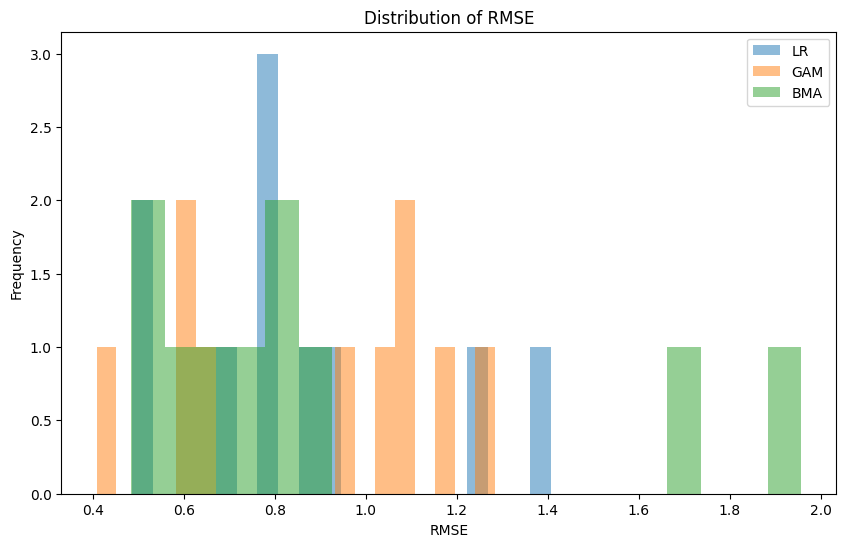

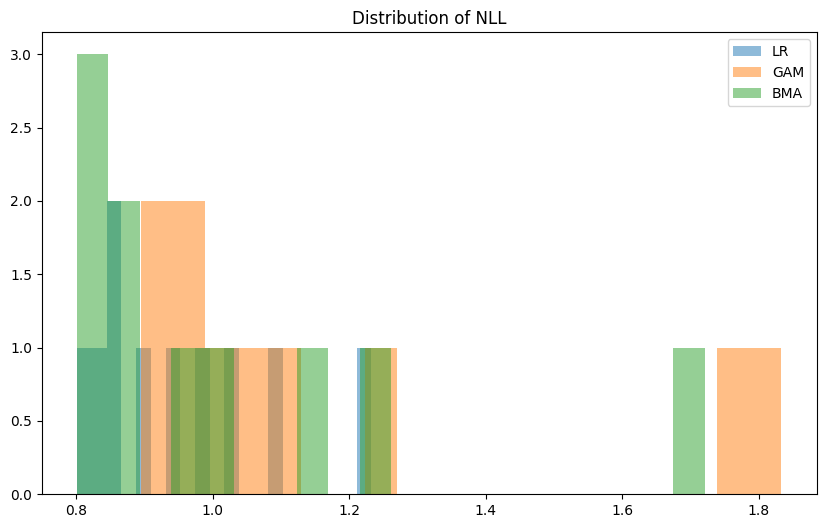

In [9]:
# Plot out distribution of RMSE error to understand why median RMSE << mean RMSE.
plt.figure(figsize=(10, 6))
plt.hist(rmse_lr, bins=20, alpha=0.5, label='LR')
plt.hist(rmse_gam, bins=20, alpha=0.5, label='GAM')
plt.hist(rmse_bma, bins=20, alpha=0.5, label='BMA')
plt.legend(loc='upper right')
plt.xlabel('RMSE')
plt.ylabel('Frequency')
plt.title('Distribution of RMSE')
plt.show()
# Plot out distribution of NLL error to understand why median NLL << mean NLL.
plt.figure(figsize=(10, 6))
plt.hist(nll_lr, bins=20, alpha=0.5, label='LR')
plt.hist(nll_gam, bins=20, alpha=0.5, label='GAM')
plt.hist(nll_bma, bins=20, alpha=0.5, label='BMA')
plt.legend(loc='upper right')
plt.title('Distribution of NLL')
plt.show()

In [2]:
# use BAE as the 1st step
# Optimization configs. 
# Consider reduce below parameters / set to `False` if MCMC is taking too long:
# mcmc_num_steps, mcmc_burnin, mcmc_nchain, mcmc_initialize_from_map.
map_step_size=5e-4   # @param
map_num_steps=10_000  # @param

mcmc_step_size=1e-4 # @param
mcmc_num_steps=1000 # @param

mcmc_nchain=10 # @param
mcmc_burnin=2_500 # @param
bne_mcmc_initialize_from_map="True" # @param ["False", "True"]

bne_mcmc_initialize_from_map = eval(bne_mcmc_initialize_from_map)


# BMA parameters.
y_noise_std = 0.01  # Note: Changed from 0.1 # @param
bma_gp_lengthscale = .55 # @param
bma_gp_l2_regularizer = .3 # @param

bma_n_samples_train = 100 # @param
bma_n_samples_eval = 250 # @param
bma_n_samples_test = 250 # @param
bma_seed = 0 # @param


# BNE parameters.
bne_gp_lengthscale = .05 # 5. # @param
bne_gp_l2_regularizer = 1. # 15 # @param
bne_variance_prior_mean = -2.5 # @param
bne_skewness_prior_mean = -2.5 # @param
bne_seed = 0 # @param


# ### Read training/prediction data
training_eastMA = pd.read_csv('../data/training_dataset/training_eastMA.csv')
training_eastMA_noMI = training_eastMA[:51]
training_eastMA_folds = pd.read_csv('../data/training_dataset/training_eastMA_folds.csv')
base_model_predictions_eastMA = pd.read_csv('../data/prediction_dataset/base_model_predictions_eastMA.csv')

print("pred longitude max and min", base_model_predictions_eastMA["lon"].max(),base_model_predictions_eastMA["lon"].min())
print("pred latitude max and min", base_model_predictions_eastMA["lat"].max(),base_model_predictions_eastMA["lat"].min())
#list(base_model_predictions_eastMA.columns)
print("train longitude max and min", training_eastMA["lon"].max(),training_eastMA["lon"].min())
print("train latitude max and min", training_eastMA["lat"].max(),training_eastMA["lat"].min())


training51= pd.read_csv('../data/training_dataset/training51.csv')

# standardize
X_train1 = np.asarray(training_eastMA_noMI[["lon", "lat"]].values.tolist()).astype(np.float32)
X_test1 = np.asarray(base_model_predictions_eastMA[["lon", "lat"]].values.tolist()).astype(np.float32)
X_valid = np.concatenate((X_train1, X_test1), axis=0)
X_centr = np.mean(X_valid, axis=0)
X_scale = np.max(X_valid, axis=0) - np.min(X_valid, axis=0)

X_train1 = (X_train1 - X_centr) / X_scale
X_test1 = (X_test1 - X_centr) / X_scale

Y_train = np.expand_dims(training_eastMA_noMI["aqs"], 1).astype(np.float32)
#Y_test = np.expand_dims(base_model_predictions_eastMA["pred_av"], 1).astype(np.float32)

print("2011 center and scale: ", X_centr, X_scale)


base_model_names = ["pred_av", "pred_gs", "pred_caces"]
base_preds_train = tf.stack([training_eastMA_noMI[base_model_name].astype(np.float32) for base_model_name in base_model_names], axis=-1)
base_preds_test = tf.stack([base_model_predictions_eastMA[base_model_name].astype(np.float32) for base_model_name in base_model_names], axis=-1)


# Assemble into configs.
bma_model_config = DEFAULT_GP_CONFIG.copy()
map_config = DEFAULT_MAP_CONFIG.copy()
mcmc_config = DEFAULT_MCMC_CONFIG.copy()

bma_model_config.update(dict(lengthscale=bma_gp_lengthscale,
                             l2_regularizer=bma_gp_l2_regularizer,
                             y_noise_std=y_noise_std,
                             #activation='relu',
                             activation_func='softmax'))
print(bma_model_config)

bma_config=dict(gp_lengthscale=bma_gp_lengthscale,
                gp_l2_regularizer=bma_gp_l2_regularizer,
                y_noise_std=y_noise_std,
                map_step_size=map_step_size,
                map_num_steps=map_num_steps,
                mcmc_step_size=mcmc_step_size,
                mcmc_num_steps=mcmc_num_steps,
                mcmc_initialize_from_map=False,
                n_samples_eval=bma_n_samples_eval,
                n_samples_train=bma_n_samples_train,
                n_samples_test=bma_n_samples_test,
                seed=bma_seed)
print(bma_config)



# BNE parameters.
bne_gp_lengthscale = 7.5  # 5. # @param
bne_gp_l2_regularizer = 10  # 15 # @param
bne_variance_prior_mean = -2.5  # @param
bne_skewness_prior_mean = -2.5  # @param
bne_seed = 0  # @param
bne_config = dict(gp_lengthscale=bne_gp_lengthscale,
                  gp_l2_regularizer=bne_gp_l2_regularizer,
                  variance_prior_mean=bne_variance_prior_mean,
                  skewness_prior_mean=bne_skewness_prior_mean,
                  map_step_size=map_step_size,
                  map_num_steps=map_num_steps,
                  mcmc_step_size=mcmc_step_size,
                  mcmc_num_steps=mcmc_num_steps,
                  mcmc_nchain=mcmc_nchain,
                  mcmc_burnin=mcmc_burnin,
                  mcmc_initialize_from_map=bne_mcmc_initialize_from_map,
                  seed=bne_seed)

print(bne_config)

map_config.update(dict(learning_rate=map_step_size,
                       num_steps=map_num_steps))

mcmc_config.update(dict(step_size=mcmc_step_size, 
                        num_steps=mcmc_num_steps,
                       burnin=mcmc_burnin,
                       nchain=mcmc_nchain,
                       debug_mode=False))



pred longitude max and min -69.93 -73.5
pred latitude max and min 44.3 40.6
train longitude max and min -70.023598 -73.443056
train latitude max and min 44.107524 40.74529
2011 center and scale:  [-72.185104  42.680347] [3.5699997 3.7000008]
{'lengthscale': 0.55, 'l2_regularizer': 0.3, 'hidden_units': 128, 'y_noise_std': 0.01, 'activation_func': 'softmax'}
{'gp_lengthscale': 0.55, 'gp_l2_regularizer': 0.3, 'y_noise_std': 0.01, 'map_step_size': 0.0005, 'map_num_steps': 10000, 'mcmc_step_size': 0.0001, 'mcmc_num_steps': 1000, 'mcmc_initialize_from_map': False, 'n_samples_eval': 250, 'n_samples_train': 100, 'n_samples_test': 250, 'seed': 0}
{'gp_lengthscale': 7.5, 'gp_l2_regularizer': 10, 'variance_prior_mean': -2.5, 'skewness_prior_mean': -2.5, 'map_step_size': 0.0005, 'map_num_steps': 10000, 'mcmc_step_size': 0.0001, 'mcmc_num_steps': 1000, 'mcmc_nchain': 10, 'mcmc_burnin': 2500, 'mcmc_initialize_from_map': True, 'seed': 0}


In [27]:
from rpy2.robjects.conversion import localconverter
from rpy2.robjects import pandas2ri, r
import rpy2.robjects as ro
import pandas as pd
from rpy2.robjects.packages import importr
from rpy2 import robjects as ro
import rpy2
kf = KFold(n_splits=10, random_state=bma_seed, shuffle=True)

rmse_lr = []
rmse_gam = []
rmse_bma = []
rmse_bae = []
rmse_bma2 = []
rmse_bma_mean = []


nll_lr, nll_gam, nll_bma_mean, nll_bma, nll_bae = [], [], [], [], []
nll_bma2 = []
# initialize a dataframe to store lon, lat and raw error
error_df = pd.DataFrame(columns=['lon', 'lat', 'raw_error'])

coverage_lr, coverage_gam, coverage_bma_mean, coverage_bma, coverage_bae = 0, 0, 0, 0, 0
coverage_bma2 = 0
#from rpy2.robjects import pandas2ri
# import R's "base" package
base = importr('base')
#ms = importr('MSGARCH')
# import R's "utils" package
utils = importr('utils')

with localconverter(ro.default_converter + pandas2ri.converter):
  # convert "lon" and "lat" in training_eastMA_noMI into scaled X_train1 values
  training_eastMA_noMI["lon"] = (
      training_eastMA_noMI["lon"] - X_centr[0]) / X_scale[0]
  training_eastMA_noMI["lat"] = (
      training_eastMA_noMI["lat"] - X_centr[1]) / X_scale[1]
  r_from_pd_df = ro.conversion.py2rpy(training_eastMA_noMI)


mgcv = importr('mgcv')
stats = importr('stats')
ciTools = importr('ciTools')


kf = KFold(n_splits=10, random_state=bma_seed, shuffle=True)
rmse_bma_mean, rmse_bma2, rmse_bae = [], [], []
for train_index, test_index in kf.split(X_train1):
    #print("Train:", train_index, "Validation:",test_index)
    X_tr, X_te = X_train1[train_index], X_train1[test_index]
    Y_tr, Y_te = Y_train[train_index], Y_train[test_index]

    base_preds_tr, base_preds_te = base_preds_train.numpy(
    )[train_index], base_preds_train.numpy()[test_index]
    print(train_index, test_index)
    print(X_tr.shape, X_te.shape, Y_tr.shape, Y_te.shape,
          base_preds_tr.shape, base_preds_te.shape)

    r_dat_py = training_eastMA_noMI

    with localconverter(ro.default_converter + pandas2ri.converter):
        r_tr = ro.conversion.py2rpy(r_dat_py.iloc[train_index])
        r_te = ro.conversion.py2rpy(r_dat_py.iloc[test_index])

    # Ref: lr
    lr_model = stats.lm(ro.Formula(
        'aqs~pred_av+pred_gs+pred_caces'), data=r_tr)
    l = ciTools.add_pi(r_te, lr_model)
    lr_pred = l[7]
    lr_ci_l, lr_ci_u = l[8], l[9]
    coverage_lr += np.sum([(Y_te[i] > lr_ci_l[i]) &
                          (Y_te[i] < lr_ci_u[i]) for i in range(len(Y_te))])
    rmse_lr.append(rmse(Y_te, np.asanyarray(lr_pred).reshape(-1, 1)))
    nll_lr.append(nll(Y_te, np.asanyarray(lr_pred).reshape(-1, 1)))
    print(rmse_lr)

    # Ref: GAM
    #df = training_eastMA_noMI.iloc[train_index]
    gam_model = mgcv.gam(ro.Formula(
        'aqs ~ s(lon, lat, by=pred_av, k=4) + s(lon, lat,by=pred_gs, k=4) +s(lon, lat, by=pred_caces, k=4)'), data=r_tr)
    a = ciTools.add_pi(r_te, gam_model)
    gam_pred = a[7]
    gam_ci_l, gam_ci_u = a[8], a[9]
    coverage_gam += np.sum([(Y_te[i] > gam_ci_l[i]) &
                           (Y_te[i] < gam_ci_u[i]) for i in range(len(Y_te))])
    rmse_gam.append(rmse(Y_te, np.asanyarray(gam_pred).reshape(-1, 1)))
    nll_gam.append(nll(Y_te, np.asanyarray(gam_pred).reshape(-1, 1)))
    print(rmse_gam)

    bma_prior, bma_gp_config = bma_dist(X_tr,
                                        base_preds_tr,
                                        **bma_model_config)

    bma_model_config.update(bma_gp_config)

    bma_gp_w_samples = run_posterior_inference(model_dist=bma_prior,
                                               model_config=bma_model_config,
                                               Y=Y_tr,
                                               map_config=map_config,
                                               mcmc_config=mcmc_config)

        #fixed_input_te = tf.ones((X_te.shape[0], 2), dtype=tf.float32)
    bma_joint_samples = make_bma_samples(X_te, None, base_preds_te,
                                         bma_weight_samples=bma_gp_w_samples[0],
                                         bma_model_config=bma_model_config,
                                         n_samples=bma_n_samples_eval,
                                         seed=bne_seed,
                                         y_samples_only=False)
    y_pred = bma_joint_samples['y']
    y_pred = tf.reduce_mean(y_pred, axis=0)
    
    print("BMA prediction", y_pred.numpy().T)
    print("LR prediction", lr_pred)
    print("GAM prediction", gam_pred)
    pred_std = calc_prediction_std(y_pred, Y_te)
    print("pred_std", pred_std)
    pred_mean = tf.reduce_mean(y_pred, axis=1)
    print("pred_mean",pred_mean)
    bma_pi = np.array([(pred_mean - 1.96*pred_std).numpy(),
                      (pred_mean + 1.96*pred_std).numpy()])
    print(bma_pi)
    rmse_bma.append(rmse(Y_te, y_pred))
    nll_bma2.append(nll(Y_te, y_pred))
    coverage_bma2 += np.sum([(Y_te[i] > bma_pi[0][i]) & (Y_te[i] < bma_pi[1][i]) for i in range(len(Y_te))])
                            
    # Create data dictionary.
    data_dicts = dict(X_train=X_tr,
                      X_test=X_te,
                      Y_train=Y_tr,
                      base_preds_train=base_preds_tr,
                      base_preds_test=base_preds_te)

    print(Y_te)
    # BMA-mean.
    print('BMA-mean:', flush=True)
    data_dict, bma_mean_joint_samples = get_bma_result(
        data_dicts, bma_config=bma_config)
    y_pred_bma_mean = np.mean(np.nan_to_num(
        bma_mean_joint_samples['y']), axis=0)
    pred_std = calc_prediction_std(y_pred_bma_mean, Y_te)
    bma_mean_pi = np.array([(y_pred_bma_mean - 1.96*pred_std).numpy(), (y_pred_bma_mean + 1.96*pred_std).numpy()])
    print(y_pred_bma_mean)

    # BMA.
    bma_var_config = bne_config.copy()
    bma_var_config['mcmc_initialize_from_map'] = bma_config['mcmc_initialize_from_map']
    bma_joint_samples = get_bne_result(data_dict, moment_mode='none',
                                       bne_config=bma_var_config)
    y_pred_bma = np.mean(np.nan_to_num(bma_joint_samples['y']), axis=0)
    print(y_pred_bma)
    pred_std = calc_prediction_std(y_pred_bma, Y_te)
    bma_pi2 = np.array([(y_pred_bma - 1.96*pred_std).numpy(), (y_pred_bma + 1.96*pred_std).numpy()])

    # BAE.
    bae_joint_samples = get_bne_result(data_dict, moment_mode='mean',
                                       bne_config=bne_config)
    y_pred_bae = np.mean(np.nan_to_num(bae_joint_samples['y']), axis=0)
    print(y_pred_bae)
    pred_std = calc_prediction_std(y_pred_bae, Y_te)
    bae_pi = np.array([(y_pred_bae - 1.96*pred_std).numpy(), (y_pred_bae + 1.96*pred_std).numpy()])
    
    # save the rmse & nll for each fold
    rmse_bma_mean.append(rmse(Y_te, y_pred_bma_mean))
    nll_bma_mean.append(nll(Y_te, y_pred_bma_mean))
    rmse_bma2.append(rmse(Y_te, y_pred_bma))
    nll_bma.append(nll(Y_te, y_pred_bma))
    rmse_bae.append(rmse(Y_te, y_pred_bae))
    nll_bae.append(nll(Y_te, y_pred_bae))
   
    # save the coverage for each fold
    coverage_bma_mean += np.sum([(Y_te[i] > bma_mean_pi[0][i]) & (Y_te[i] < bma_mean_pi[1][i]) for i in range(len(Y_te))])
    coverage_bma += np.sum([(Y_te[i] > bma_pi2[0][i]) & (Y_te[i] < bma_pi2[1][i]) for i in range(len(Y_te))])
    coverage_bae += np.sum([(Y_te[i] > bae_pi[0][i]) & (Y_te[i] < bae_pi[1][i]) for i in range(len(Y_te))])
    
    raw_error = pd.DataFrame(columns=['lon', 'lat', 'raw_error'])
    raw_error["lon"] = X_te[:,0]
    raw_error["lat"] = X_te[:,1]
    raw_error["raw_error"] = (y_pred_bae - Y_te).reshape(-1)
    error_df = error_df.append(raw_error)
    print("rmse:", flush=True)
    print(rmse_bma_mean, rmse_bma2, rmse_bae)
    print("nll:", flush=True)
    print(nll_bma_mean, nll_bma, nll_bae)

    # raw_error = pd.DataFrame(columns=['lon', 'lat', 'raw_error'])
    # raw_error["lon"] = X_te[:, 0]
    # raw_error["lat"] = X_te[:, 1]
    # raw_error["raw_error"] = (y_pred - Y_te).numpy().reshape(-1)
    # error_df = error_df.append(raw_error)

    # pred_std = calc_prediction_std(y_pred, Y_te)
    # pred_mean = tf.reduce_mean(y_pred, axis=1)
    # bma_pi = np.array([(pred_mean - 1.96*pred_std).numpy(),
    #                   (pred_mean + 1.96*pred_std).numpy()])
    # coverage_bma += np.sum([(Y_te[i] > bma_pi[0][i]) &
    #                        (Y_te[i] < bma_pi[1][i]) for i in range(len(Y_te))])
    # rmse_bma.append(rmse(Y_te, y_pred))
    # nll_bma.append(nll(Y_te, y_pred))
    # print(rmse_bma)
    # Investigate what examples (e.g., in terms of spatial coordinate) tend to receive high error.

# # save rmse average among folds
# average_metrics = np.mean(
#     [rmse_bma_mean, rmse_bma2, rmse_bae], axis=1)
# print(average_metrics)

print("RMSE LR: ", np.mean(rmse_lr), np.median(rmse_lr), np.std(rmse_lr))
print("RMSE GAM: ", np.mean(rmse_gam), np.median(rmse_gam), np.std(rmse_gam))
print("RMSE BMA-mean: ", np.mean(rmse_bma_mean), np.median(rmse_bma_mean), np.std(rmse_bma_mean))
print("RMSE BMA: ", np.mean(rmse_bma2), np.median(rmse_bma2), np.std(rmse_bma2))
print("RMSE BAE: ", np.mean(rmse_bae), np.median(rmse_bae), np.std(rmse_bae))

print("NLL LR: ", np.mean(nll_lr), np.median(nll_lr), np.std(nll_lr))
print("NLL GAM: ", np.mean(nll_gam), np.median(nll_gam), np.std(nll_gam))
print("NLL BMA-mean: ", np.mean(nll_bma_mean), np.median(nll_bma_mean), np.std(nll_bma_mean))
print("NLL BMA: ", np.mean(nll_bma), np.median(nll_bma), np.std(nll_bma))
print("NLL BAE: ", np.mean(nll_bae), np.median(nll_bae), np.std(nll_bae))

print("Coverage LR: ", coverage_lr/len(Y_train))
print("Coverage GAM: ", coverage_gam/len(Y_train))
print("Coverage BMA-mean: ", coverage_bma_mean/len(Y_train))
print("Coverage BMA: ", coverage_bma/len(Y_train))
print("Coverage BAE: ", coverage_bae/len(Y_train))

print("coverage bma 2", flush=True)
print(coverage_bma2/len(Y_train))

/Users/liyanran/opt/anaconda3/envs/BNE/lib/python3.7/site-packages/ipykernel_launcher.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/liyanran/opt/anaconda3/envs/BNE/lib/python3.7/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


[ 0  1  3  4  5  6  7  8  9 12 13 14 15 16 17 18 19 20 21 23 24 25 26 27
 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50] [ 2 10 11 22 28 29]
(45, 2) (6, 2) (45, 1) (6, 1) (45, 3) (6, 3)
[0.4849554265795824]
[0.40761262064273013]
activation function used softmax
Running MAP:	360300.6875...199465.75...191216.0...187648.515625...184917.0625...182011.34375...179152.0625...176142.75...173089.359375...170184.375...Done.
Running MCMC:	Acceptance Ratio: 0.7667247653007507
activation function used softmax
BMA prediction [[10.000861   9.700449   6.5291615  9.199209   6.0986676  9.199632 ]]
LR prediction [1] 10.122534  9.868970  5.900925  9.721513  5.350043  9.428457

GAM prediction [1] 10.211692  9.819234  5.673587  9.639126  5.343896  9.012283

pred_std tf.Tensor(0.46708164, shape=(), dtype=float32)
pred_mean tf.Tensor([10.000861   9.700449   6.5291615  9.199209   6.0986676  9.199632 ], shape=(6,), dtype=float32)
[[ 9.0853815  8.784969   5.6136813  8.28373    5.1831875  8.28415

In [26]:
print("RMSE LR: ", np.mean(rmse_lr), np.median(rmse_lr), np.std(rmse_lr))
print("RMSE GAM: ", np.mean(rmse_gam), np.median(rmse_gam), np.std(rmse_gam))
print("RMSE BMA-mean: ", np.mean(rmse_bma_mean), np.median(rmse_bma_mean), np.std(rmse_bma_mean))
print("RMSE BMA: ", np.mean(rmse_bma2), np.median(rmse_bma2), np.std(rmse_bma2))
print("RMSE BAE: ", np.mean(rmse_bae), np.median(rmse_bae), np.std(rmse_bae))

print("NLL LR: ", np.mean(nll_lr), np.median(nll_lr), np.std(nll_lr))
print("NLL GAM: ", np.mean(nll_gam), np.median(nll_gam), np.std(nll_gam))
print("NLL BMA-mean: ", np.mean(nll_bma_mean), np.median(nll_bma_mean), np.std(nll_bma_mean))
print("NLL BMA: ", np.mean(nll_bma), np.median(nll_bma), np.std(nll_bma))
print("NLL BAE: ", np.mean(nll_bae), np.median(nll_bae), np.std(nll_bae))

print("Coverage LR: ", coverage_lr/len(Y_train))
print("Coverage GAM: ", coverage_gam/len(Y_train))
print("Coverage BMA-mean: ", coverage_bma_mean/len(Y_train))
print("Coverage BMA: ", coverage_bma/len(Y_train))
print("Coverage BAE: ", coverage_bae/len(Y_train))

print("coverage bma 2", flush=True)
print(coverage_bma2/len(Y_train))

RMSE LR:  0.8535467618362297 0.799006139404427 0.2755349737889978
RMSE GAM:  0.8906541796017822 1.000680723615343 0.2787684492528292
RMSE BMA-mean:  0.9128458 0.7917347 0.44186258
RMSE BMA:  0.9128458 0.7917347 0.44186258
RMSE BAE:  0.8941223 0.7671427 0.44753078
NLL LR:  0.95211065 0.91061574 0.12822385
NLL GAM:  1.1780632 1.0415206 0.3268624
NLL BMA-mean:  1.0489732 0.954573 0.26746517
NLL BMA:  1.0489732 0.954573 0.26746517
NLL BAE:  0.9700297 0.87525725 0.21393003
Coverage LR:  0.9411764705882353
Coverage GAM:  0.9019607843137255
Coverage BMA-mean:  0.9215686274509803
Coverage BMA:  0.9215686274509803
Coverage BAE:  0.9411764705882353
coverage bma 2
0.9607843137254902


In [24]:

print("RMSE LR: ", np.mean(rmse_lr), np.median(rmse_lr), np.std(rmse_lr))
print("RMSE GAM: ", np.mean(rmse_gam), np.median(rmse_gam), np.std(rmse_gam))
print("RMSE BMA: ", np.mean(rmse_bma2), np.median(rmse_bma2), np.std(rmse_bma2))
print("RMSE BMA-Mean: ", np.mean(rmse_bma_mean), np.median(rmse_bma_mean), np.std(rmse_bma_mean))
print("RMSE BMA:", np.mean(rmse_bma), np.median(rmse_bma), np.std(rmse_bma))
print("RMSE BAE: ", np.mean(rmse_bae), np.median(rmse_bae), np.std(rmse_bae))

print("RMSE BMA-Mean: ", rmse_bma_mean)
print("RMSE BMA:", rmse_bma)
print("RMSE BAE: ", rmse_bae)


RMSE LR:  0.8535467618362297 0.799006139404427 0.2755349737889978
RMSE GAM:  0.8906541796017822 1.000680723615343 0.2787684492528292
RMSE BMA:  0.9128458 0.7917347 0.44186258
RMSE BMA-Mean:  0.9128458 0.7917347 0.44186258
RMSE BMA: 0.90089035 0.69356775 0.4916007
RMSE BAE:  0.8941223 0.7671427 0.44753078
RMSE BMA-Mean:  [0.5096889, 0.48968843, 1.5228623, 0.7968115, 0.80480194, 0.7866578, 0.9330785, 0.6336097, 0.70173645, 1.9495219]
RMSE BMA: [0.5184996, 0.4869609, 1.7351234, 0.8082389, 0.60736626, 0.9227745, 0.7517346, 0.63540095, 0.58558244, 1.957222]
RMSE BAE:  [0.40076494, 0.4618366, 1.5521771, 0.85629296, 0.9825734, 0.7194507, 0.8148347, 0.5938562, 0.6856015, 1.8738352]
